In [23]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

***Question 1: Asset Allocation***

1. Based on Aswath Damodoran’s data, what are the empirical properties (Sharpe ratio, annualized return, correlation) of different asset classes?

In [18]:
# Load Aswath Damodoran's data
AS_data_path = "/Users/eric_p/Desktop/Sping 2026/MFIN 7037/Homework1/histretSP.csv"
AS_data = pd.read_csv(AS_data_path)
AS_data.rename(columns = {
    ' Baa Corporate Bond': 'Baa Corporate Bond'
}, inplace = True)


In [19]:
asset_class = ['S&P 500 (includes dividends)', 'US Small cap (bottom decile)',
       '3-month T.Bill', 'US T. Bond (10-year)', 'Baa Corporate Bond',
       'Real Estate', 'Gold*']
asset_returns_panel = AS_data[asset_class].copy()

# Convert percentage strings to floats
for asset in asset_class:
    asset_returns_panel[asset] = asset_returns_panel[asset].str.rstrip('%').astype(float) / 100
asset_returns_panel.dropna()

# Calculate arithmetic mean for each asset class
asset_arith_means = asset_returns_panel.mean()

# Risk-free rate (arithmetic mean of T.Bill)
RF = asset_arith_means['3-month T.Bill']

# Calculate sharpe ratio for each asset class
asset_std = asset_returns_panel.std()
asset_sharpe = (asset_arith_means - RF) / asset_std

# Calculate geometric means (for annualized returns)
n = len(asset_returns_panel)
asset_geo_means = (1 + asset_returns_panel).prod() ** (1 / n) - 1

# Establish correlation matrix
asset_corr_mat = asset_returns_panel.corr()

# Output
summary = pd.DataFrame({
    'Geometric Mean': asset_geo_means,
    'Arithmetic Mean': asset_arith_means,
    'Std Dev': asset_std,
    'Sharpe Ratio': asset_sharpe
})


In [4]:
# Print out summary statistics
summary_styled = summary.style.format({
    'Geometric Mean': '{:.2%}',
    'Arithmetic Mean': '{:.2%}',
    'Std Dev': '{:.2%}',
    'Sharpe Ratio': '{:.3f}'
}).background_gradient(
    cmap='RdYlGn', 
    subset=['Sharpe Ratio'], 
    vmin=0, vmax=summary['Sharpe Ratio'].max()
).background_gradient(
    cmap='Blues', 
    subset=['Geometric Mean', 'Arithmetic Mean'],
    vmin=0
).set_caption('Asset Class Historical Statistics (1928–2025)') \
 .set_table_styles([
     {'selector': 'caption', 'props': 'caption-side: top; font-size: 16px; font-weight: bold; color: #333;'},
     {'selector': 'th', 'props': 'background-color: #2c3e50; color: white; text-align: center;'},
     {'selector': 'td', 'props': 'text-align: center;'}
 ])

print("\nSummary Statistics:")
display(summary_styled)

# Print out correlation matrix
corr_styled = asset_corr_mat.round(3).style\
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)\
    .format('{:.3f}')\
    .set_caption('Correlation Matrix')\
    .set_table_styles([
        {'selector': 'caption', 'props': 'font-size: 16px; font-weight: bold; color: #333;'},
        {'selector': 'th', 'props': 'background-color: #34495e; color: white;'},
        {'selector': 'td', 'props': 'text-align: center;'}
    ])

print("\nCorrelation Matrix:")
display(corr_styled)


Summary Statistics:


,Geometric Mean,Arithmetic Mean,Std Dev,Sharpe Ratio
S&P 500 (includes dividends),10.02%,11.85%,19.40%,0.435
US Small cap (bottom decile),11.98%,17.78%,37.95%,0.378
3-month T.Bill,3.37%,3.42%,3.04%,0.000
US T. Bond (10-year),4.53%,4.82%,7.90%,0.178
Baa Corporate Bond,6.63%,6.90%,7.65%,0.456
Real Estate,4.20%,4.38%,6.18%,0.156
Gold*,5.61%,7.36%,21.51%,0.183



Correlation Matrix:


,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*
S&P 500 (includes dividends),1.000,0.721,-0.021,0.018,0.404,0.148,-0.056
US Small cap (bottom decile),0.721,1.000,-0.151,-0.102,0.312,0.153,0.011
3-month T.Bill,-0.021,-0.151,1.000,0.279,0.120,0.077,0.135
US T. Bond (10-year),0.018,-0.102,0.279,1.000,0.658,-0.108,-0.009
Baa Corporate Bond,0.404,0.312,0.120,0.658,1.000,-0.043,0.017
Real Estate,0.148,0.153,0.077,-0.108,-0.043,1.000,0.078
Gold*,-0.056,0.011,0.135,-0.009,0.017,0.078,1.000


2. If you segmented on the last 30 years, how would the optimal asset allocation differ from the prior period? What asset classes stand out? Meanwhile, find a capital market assumption from a reputable financial institution for the next 5, 10 or 20 years? What does this imply about the importance and fragility of capital market assumptions?


In [20]:
# Split the entire time period into two segments. The first is from 1928 to 1995 and the second is from 1996 until now.
segment_analysis_df = AS_data[['Year'] + asset_class].copy()
segment_analysis_df['Year'] = segment_analysis_df['Year'].astype(int)

## Convert percentage strings to floats (e.g., '43.81%' -> 0.4381)
for asset in asset_class:
    segment_analysis_df[asset] = segment_analysis_df[asset].str.rstrip('%').astype(float) / 100
segment_analysis_df.dropna()

segment1_df = segment_analysis_df[segment_analysis_df['Year'] < 1996]
segment2_df = segment_analysis_df[segment_analysis_df['Year'] >= 1996]

segment1_df = segment1_df.drop(columns = ['Year'])
segment2_df = segment2_df.drop(columns = ['Year'])

In [28]:
# Calculate corresponding statistics and correlation matrix for each segment
def calculate_stats(segment_df):
    # Compute arithmetic mean
    arith_means = segment_df.mean()
    
    # Compute standard deviation
    std = segment_df.std()
    RF = arith_means['3-month T.Bill']  
    
    # Compute sharpe ratio
    sharpe = (arith_means - RF) / std
    
    # Compute geometric means
    n = len(segment_df)
    geo_means = (1 + segment_df).prod() ** (1 / n) - 1
    
    stats = pd.DataFrame({
        'Geometric Mean': geo_means,
        'Arithmetic Mean': arith_means,
        'Std Dev': std,
        'Sharpe Ratio': sharpe
    })
    
    # 美观显示（百分比 + 颜色）
    styled = stats.style.format({
        'Geometric Mean': '{:.2%}',
        'Arithmetic Mean': '{:.2%}',
        'Std Dev': '{:.2%}',
        'Sharpe Ratio': '{:.3f}'
    }).background_gradient(
        cmap='RdYlGn', subset=['Sharpe Ratio'], vmin=0
    ).background_gradient(
        cmap='Blues', subset=['Geometric Mean', 'Arithmetic Mean'], vmin=0
    )
    
    return styled, stats

In [29]:
# Compute summary statistics for both segments
segment1_summary, segment1_stats = calculate_stats(segment1_df)
segment2_summary, segment2_stats = calculate_stats(segment2_df)

# Output
print("\n1928-1995 Summary Statistics:")
display(segment1_summary)

print("\n1996-2025 Summary Statistics:")
display(segment2_summary)


1928-1995 Summary Statistics:


,Geometric Mean,Arithmetic Mean,Std Dev,Sharpe Ratio
S&P 500 (includes dividends),9.91%,11.88%,20.28%,0.394
US Small cap (bottom decile),13.10%,20.15%,42.13%,0.386
3-month T.Bill,3.83%,3.88%,3.27%,0.000
US T. Bond (10-year),4.83%,5.08%,7.53%,0.159
Baa Corporate Bond,6.77%,7.06%,8.01%,0.397
Real Estate,3.95%,4.13%,6.16%,0.040
Gold*,4.40%,6.28%,22.86%,0.105



1996-2025 Summary Statistics:


,Geometric Mean,Arithmetic Mean,Std Dev,Sharpe Ratio
S&P 500 (includes dividends),10.26%,11.80%,17.59%,0.537
US Small cap (bottom decile),9.49%,12.39%,25.95%,0.387
3-month T.Bill,2.33%,2.35%,2.12%,0.000
US T. Bond (10-year),3.86%,4.23%,8.79%,0.214
Baa Corporate Bond,6.31%,6.53%,6.89%,0.607
Real Estate,4.75%,4.94%,6.30%,0.411
Gold*,8.39%,9.81%,18.17%,0.410


In [21]:
# Get the optimal asset allocation strategy in each time period
# ────────────────────────────────────────────────────────────────
# Function to find max-Sharpe portfolio (long-only)
def get_max_sharpe_weights(returns_df, rf_col='3-month T.Bill'):
    """
    Returns optimal weights that maximize Sharpe ratio.
    Assumes returns_df contains only return columns (no 'Year').
    """
    mean_returns = returns_df.mean()
    cov_matrix   = returns_df.cov()
    rf_rate      = mean_returns[rf_col]
    
    num_assets = len(mean_returns)
    
    def negative_sharpe(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol    = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        if port_vol == 0:
            return 0
        return - (port_return - rf_rate) / port_vol
    
    # Constraints: weights sum to 1, each weight >= 0
    constraints = ({'type': 'eq',   'fun': lambda w: np.sum(w) - 1})
    bounds      = tuple((0, 1) for _ in range(num_assets))
    init_guess  = np.array([1.0 / num_assets] * num_assets)
    
    result = minimize(
        negative_sharpe,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )
    
    if result.success:
        return result.x
    else:
        print("Optimization failed:", result.message)
        return np.full(num_assets, np.nan)

# ────────────────────────────────────────────────────────────────
# Compute for both periods
weights_segment1 = get_max_sharpe_weights(segment1_df)
weights_segment2 = get_max_sharpe_weights(segment2_df)

# ────────────────────────────────────────────────────────────────
# Pretty print non-zero weights
def print_optimal_allocation(weights, assets, title):
    print("-" * 50)
    print(f"{title}")
    print("-" * 50)
    if np.all(np.isnan(weights)):
        print("No valid solution found")
        return
    
    s = pd.Series(weights, index=assets).sort_values(ascending=False)
    non_zero = s[s > 0.001]  # ignore tiny weights
    if non_zero.empty:
        print("All weights near zero or invalid")
    else:
        for asset, w in non_zero.items():
            print(f"{asset:<35} {w:>7.2%}")
    
    print("=" * 50)

print_optimal_allocation(weights_segment1, asset_class, "Optimal Allocation: 1928-1995")
print_optimal_allocation(weights_segment2, asset_class, "Optimal Allocation: 1996-present")

--------------------------------------------------
Optimal Allocation: 1928-1995
--------------------------------------------------
Baa Corporate Bond                   68.26%
S&P 500 (includes dividends)         12.08%
Gold*                                10.77%
US Small cap (bottom decile)          8.89%
--------------------------------------------------
Optimal Allocation: 1996-present
--------------------------------------------------
Real Estate                          42.55%
US T. Bond (10-year)                 18.79%
Baa Corporate Bond                   14.41%
Gold*                                12.47%
S&P 500 (includes dividends)         11.77%


6. If Hong Kongers could have also invested in European, North American, or other Asian funds? 

In [6]:
# Load category data
category_path = "/Users/eric_p/Desktop/Sping 2026/MFIN 7037/Homework1/mpf_category_annual_returns.csv"
category_df = pd.read_csv(category_path)

Text(0.5, 0.005, 'Counterfactual is 1.26× richer  |  Extra $0.3612 per $1 invested  |  +1.48% p.a.')

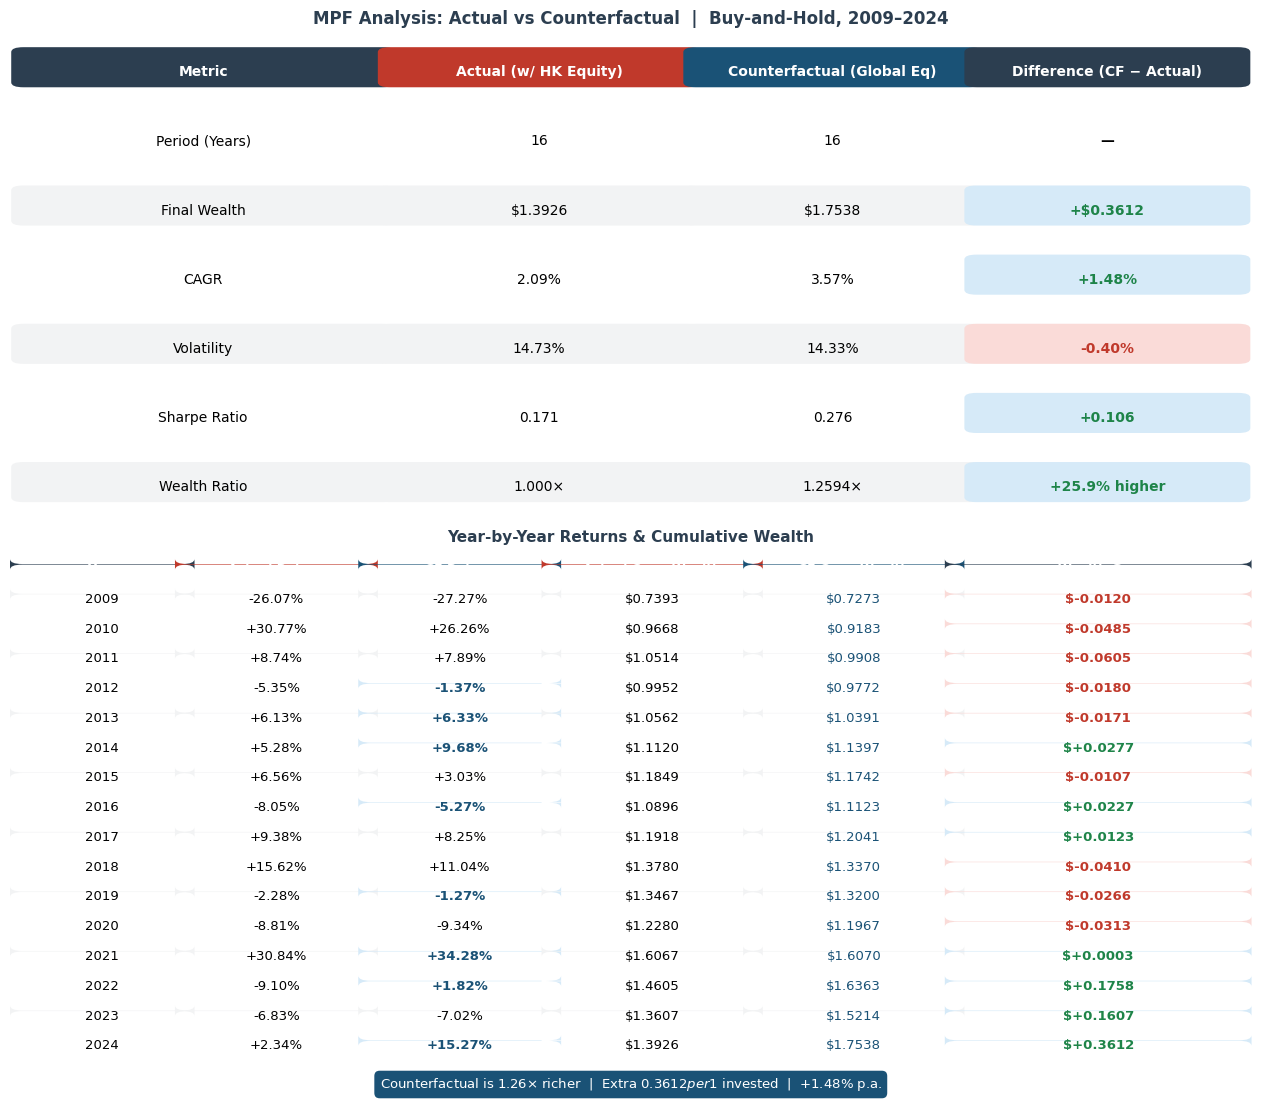

In [24]:
# ── 1. Column names & weights ─────────────────────────────────────────────────
COL_YEAR   = "hk_year"
COL_CASH   = "hk_AsiaMoneyMarket"
COL_BOND   = "hk_GlobalFixedIncome"
COL_HK_EQ  = "hk_GreaterChinaEquity"
COL_GL_EQ  = "hk_GlobalEquityLargeCap"

w_cash         = 0.15
w_bond         = 0.21
w_hk_equity    = 0.34
w_global_equity = 0.30

# ── 2. Filter from 2009 ───────────────────────────────────────────────────────
START_YEAR = 2009
df = category_df[category_df[COL_YEAR] >= START_YEAR].copy().reset_index(drop=True)

asset_cols = [COL_CASH, COL_BOND, COL_HK_EQ, COL_GL_EQ]
R  = df[asset_cols].astype(float)
rf = df[COL_CASH].astype(float)
years = df[COL_YEAR].values

# ── 3. Weight vectors ─────────────────────────────────────────────────────────
W_actual = np.array([w_cash, w_bond, w_hk_equity,                  w_global_equity], dtype=float)
W_cf     = np.array([w_cash, w_bond, 0.0,          w_global_equity + w_hk_equity],  dtype=float)

assert abs(W_actual.sum() - 1.0) < 1e-9
assert abs(W_cf.sum()    - 1.0) < 1e-9

# ── 4. Drift simulation ───────────────────────────────────────────────────────
def portfolio_drift(returns_df: pd.DataFrame, weights0: np.ndarray):
    w = weights0.copy().astype(float)
    port_rets, weight_history = [], []
    for row in returns_df.values:
        r_port = float(np.dot(w, row))
        port_rets.append(r_port)
        w = w * (1.0 + row)
        w = w / w.sum()
        weight_history.append(w.copy())
    return (
        pd.Series(port_rets, index=returns_df.index),
        pd.DataFrame(weight_history, columns=returns_df.columns, index=returns_df.index),
    )

actual_rets, w_path_actual = portfolio_drift(R, W_actual)
cf_rets,     w_path_cf     = portfolio_drift(R, W_cf)

# ── 5. Performance statistics ─────────────────────────────────────────────────
def perf_stats(port_rets: pd.Series, rf_series: pd.Series) -> dict:
    r    = port_rets.dropna().astype(float)
    rf_a = rf_series.loc[r.index].astype(float)
    ex   = r - rf_a
    n    = len(r)
    final_wealth = float((1.0 + r).prod())
    cagr         = final_wealth ** (1.0 / n) - 1.0
    vol          = float(r.std(ddof=1))
    sharpe       = float(ex.mean() / r.std(ddof=1))
    return {"n_years": n, "final_wealth": final_wealth,
            "cagr": cagr, "vol": vol, "sharpe": sharpe}

stats_actual = perf_stats(actual_rets, rf)
stats_cf     = perf_stats(cf_rets,     rf)

# ── 6. Year-by-year comparison ────────────────────────────────────────────────
annual = pd.DataFrame({
    "year":             years,
    "actual_ret":       actual_rets.values,
    "cf_ret":           cf_rets.values,
    "actual_cumwealth": (1.0 + actual_rets).cumprod().values,
    "cf_cumwealth":     (1.0 + cf_rets).cumprod().values,
})
annual["wealth_gap"] = annual["cf_cumwealth"] - annual["actual_cumwealth"]

wealth_ratio = stats_cf["final_wealth"] / stats_actual["final_wealth"]
cagr_diff    = stats_cf["cagr"] - stats_actual["cagr"]
extra        = stats_cf["final_wealth"] - stats_actual["final_wealth"]

# ── 7. Matplotlib tables ──────────────────────────────────────────────────────
C_RED    = "#C0392B";  C_RED_L  = "#FADBD8"
C_BLUE   = "#1A5276";  C_BLUE_L = "#D6EAF8"
C_HEAD   = "#2C3E50";  C_GREY_L = "#F2F3F4"
C_GREEN  = "#1E8449";  C_AMBER  = "#C0392B"

fig = plt.figure(figsize=(13, 11))
fig.patch.set_facecolor("white")

# ── Table 1: Performance Summary (top half) ───────────────────────────────────
ax1 = fig.add_axes([0.03, 0.52, 0.94, 0.44])
ax1.set_axis_off()

sum_rows = [
    ("Metric",           "Actual (w/ HK Equity)", "Counterfactual (Global Eq)", "Difference (CF − Actual)"),
    ("Period (Years)",   f"{stats_actual['n_years']}",  f"{stats_cf['n_years']}",  "—"),
    ("Final Wealth",     f"${stats_actual['final_wealth']:.4f}", f"${stats_cf['final_wealth']:.4f}", f"+${extra:.4f}"),
    ("CAGR",             f"{stats_actual['cagr']:.2%}",  f"{stats_cf['cagr']:.2%}",  f"{cagr_diff:+.2%}"),
    ("Volatility",       f"{stats_actual['vol']:.2%}",   f"{stats_cf['vol']:.2%}",    f"{stats_cf['vol']-stats_actual['vol']:+.2%}"),
    ("Sharpe Ratio",     f"{stats_actual['sharpe']:.3f}",f"{stats_cf['sharpe']:.3f}", f"{stats_cf['sharpe']-stats_actual['sharpe']:+.3f}"),
    ("Wealth Ratio",     "1.000×", f"{wealth_ratio:.4f}×", f"{wealth_ratio-1:+.1%} higher"),
]

col_x = [0.0, 0.30, 0.55, 0.78]
col_w = [0.30, 0.25, 0.23, 0.22]
row_h = 1.0 / len(sum_rows)

def draw_cell(ax, row, col, text, bg, fg="black", bold=False, size=10.5):
    x = col_x[col]; y = 1.0 - (row + 1) * row_h
    rect = mpatches.FancyBboxPatch(
        (x + 0.003, y + 0.05), col_w[col] - 0.006, row_h - 0.08,
        boxstyle="round,pad=0.01", linewidth=0,
        facecolor=bg, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(x + col_w[col]/2, y + row_h/2, text,
            transform=ax.transAxes, ha="center", va="center",
            fontsize=size, fontweight="bold" if bold else "normal",
            color=fg, fontfamily="sans-serif")

# Title
ax1.text(0.5, 1.02, "MPF Analysis: Actual vs Counterfactual  |  Buy-and-Hold, 2009–2024",
         transform=ax1.transAxes, ha="center", va="bottom",
         fontsize=12, fontweight="bold", color=C_HEAD)

for i, row_data in enumerate(sum_rows):
    is_header = (i == 0)
    bg_row = C_GREY_L if (i % 2 == 0 and not is_header) else "white"
    for j, text in enumerate(row_data):
        if is_header:
            bgs = [C_HEAD, C_RED, C_BLUE, C_HEAD]
            draw_cell(ax1, i, j, text, bgs[j], fg="white", bold=True, size=10)
        else:
            # highlight diff column
            if j == 3:
                is_pos = text.startswith("+")
                bg = C_BLUE_L if is_pos else C_RED_L if text.startswith("-") else bg_row
                fg = C_GREEN  if is_pos else C_AMBER  if text.startswith("-") else "black"
                draw_cell(ax1, i, j, text, bg, fg=fg, bold=True, size=10)
            else:
                draw_cell(ax1, i, j, text, bg_row, size=10)

# ── Table 2: Year-by-year (bottom half) ───────────────────────────────────────
ax2 = fig.add_axes([0.03, 0.03, 0.94, 0.46])
ax2.set_axis_off()

ann_cols = ["Year", "Actual Return", "CF Return", "Actual Cum. Wealth", "CF Cum. Wealth", "Wealth Gap"]
col_x2 = [0.0, 0.135, 0.285, 0.435, 0.60, 0.765]
col_w2 = [0.135, 0.15, 0.15, 0.165, 0.165, 0.235]
n_ann  = len(annual) + 1   # +1 header
row_h2 = 1.0 / n_ann

def draw_cell2(ax, row, col, text, bg, fg="black", bold=False, size=9.5):
    x = col_x2[col]; y = 1.0 - (row + 1) * row_h2
    rect = mpatches.FancyBboxPatch(
        (x + 0.002, y + 0.05), col_w2[col] - 0.004, row_h2 - 0.08,
        boxstyle="round,pad=0.01", linewidth=0,
        facecolor=bg, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(x + col_w2[col]/2, y + row_h2/2, text,
            transform=ax.transAxes, ha="center", va="center",
            fontsize=size, fontweight="bold" if bold else "normal",
            color=fg, fontfamily="sans-serif")

ax2.text(0.5, 1.02, "Year-by-Year Returns & Cumulative Wealth",
         transform=ax2.transAxes, ha="center", va="bottom",
         fontsize=11, fontweight="bold", color=C_HEAD)

hdr_colors2 = [C_HEAD, C_RED, C_BLUE, C_RED, C_BLUE, C_HEAD]
for j, (lbl, hc) in enumerate(zip(ann_cols, hdr_colors2)):
    draw_cell2(ax2, 0, j, lbl, hc, fg="white", bold=True, size=9)

for i, row_data in annual.iterrows():
    r      = i + 1
    bg_row = C_GREY_L if i % 2 == 0 else "white"
    gap    = row_data["wealth_gap"]
    gap_bg = C_BLUE_L if gap >= 0 else C_RED_L
    gap_fg = C_GREEN  if gap >= 0 else C_AMBER
    cf_ahead = row_data["cf_ret"] > row_data["actual_ret"]

    cells = [
        (str(int(row_data["year"])),                       bg_row,  "black",  False),
        (f"{row_data['actual_ret']:+.2%}",                 bg_row,  "black",  False),
        (f"{row_data['cf_ret']:+.2%}",                     C_BLUE_L if cf_ahead else bg_row, C_BLUE if cf_ahead else "black", cf_ahead),
        (f"${row_data['actual_cumwealth']:.4f}",           bg_row,  "black",  False),
        (f"${row_data['cf_cumwealth']:.4f}",               bg_row,  C_BLUE,   False),
        (f"${gap:+.4f}",                                   gap_bg,  gap_fg,   True),
    ]
    for j, (text, bg, fg, bold) in enumerate(cells):
        draw_cell2(ax2, r, j, text, bg, fg=fg, bold=bold, size=9.5)

# Footer
fig.text(0.5, 0.005,
         f"Counterfactual is {wealth_ratio:.2f}× richer  |  Extra ${extra:.4f} per $1 invested  |  +{cagr_diff:.2%} p.a.",
         ha="center", fontsize=9.5, color="white",
         bbox=dict(boxstyle="round,pad=0.4", facecolor=C_BLUE, linewidth=0))


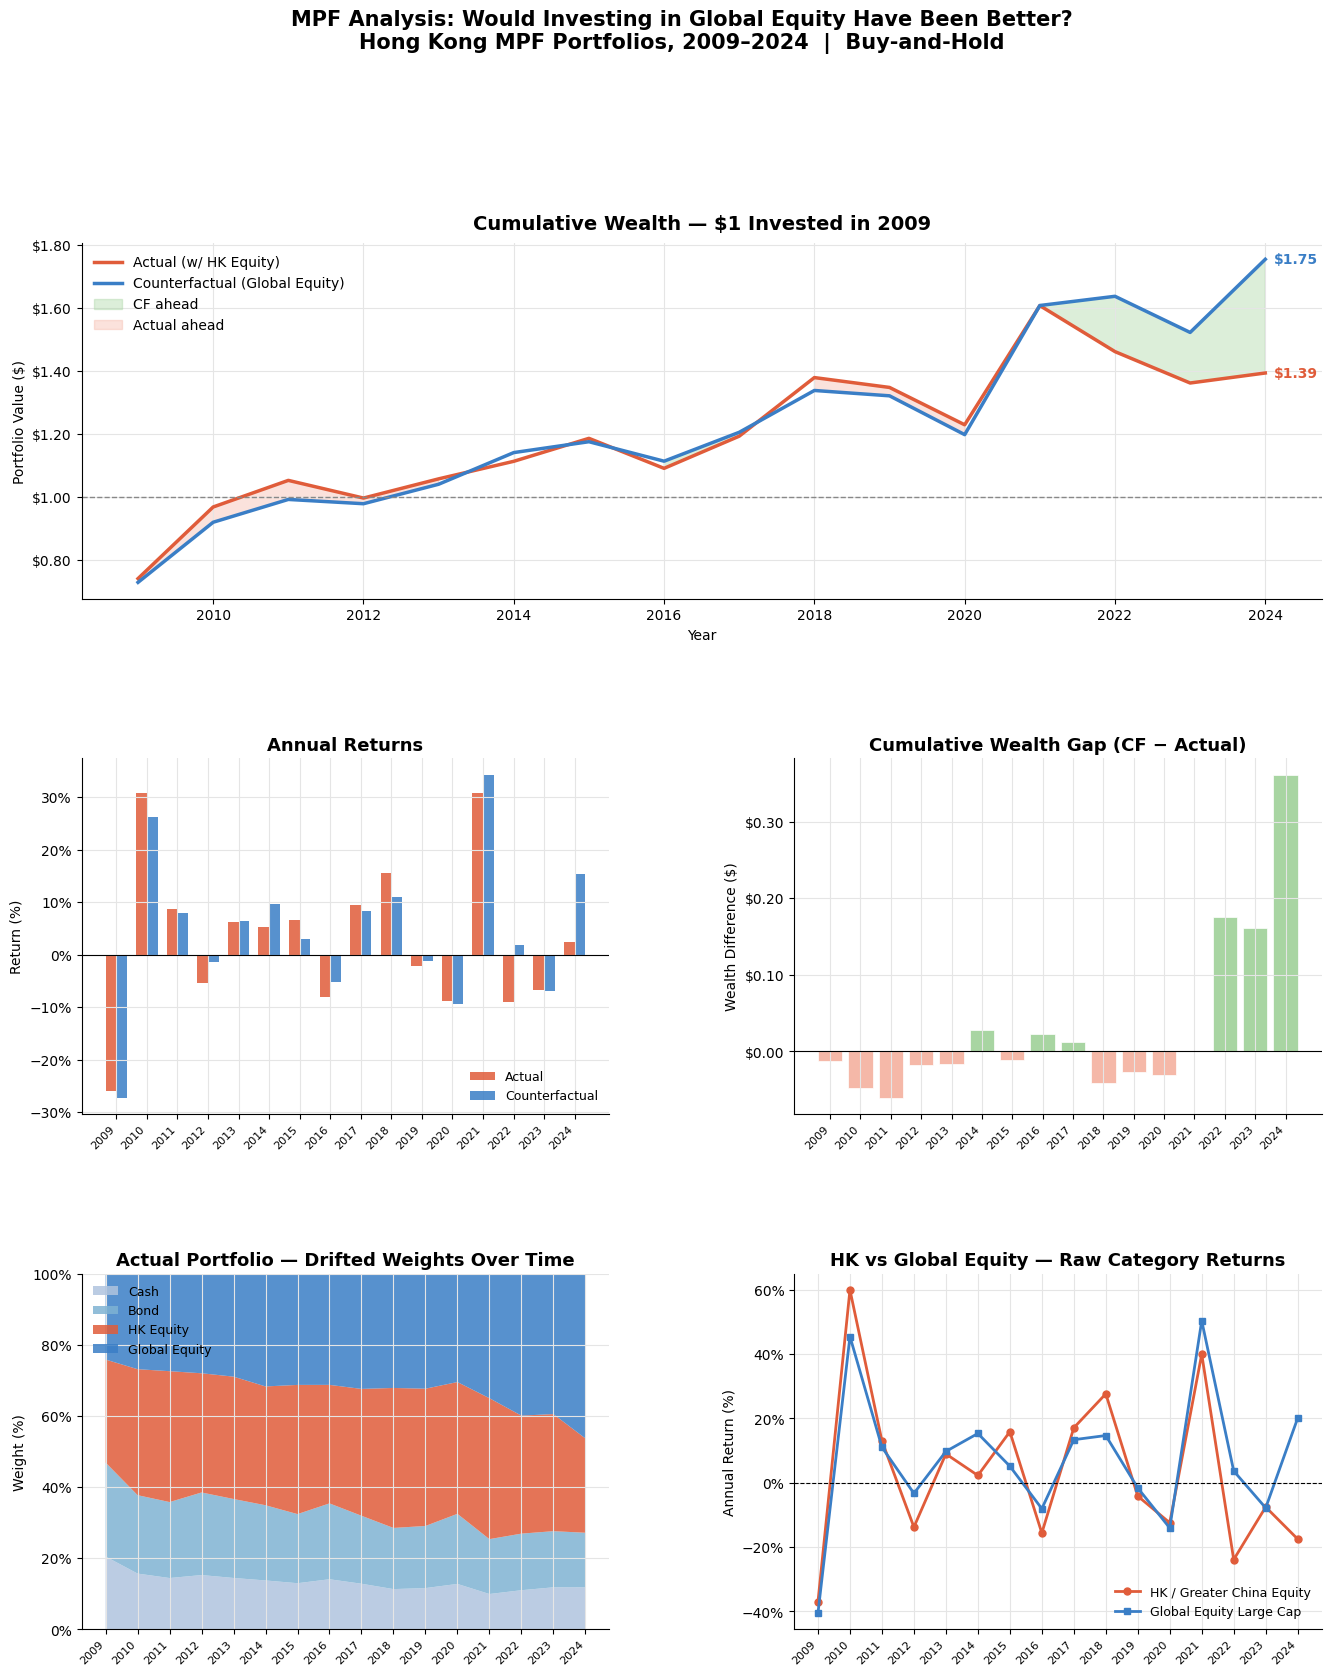

In [ ]:
actual_rets, w_path_actual = portfolio_drift(R, W_actual)
cf_rets,     w_path_cf     = portfolio_drift(R, W_cf)

cum_actual = (1 + actual_rets).cumprod()
cum_cf     = (1 + cf_rets).cumprod()

# ── Colour palette ─────────────────────────────────────────────────────────────
C_ACTUAL = "#E05C3A"   # warm red  → HK-heavy
C_CF     = "#3A7EC6"   # blue      → Global
C_GAP    = "#A8D5A2"   # soft green for positive gap fill
C_NEG    = "#F5B8A8"   # soft red for negative gap fill
GREY     = "#888888"

plt.rcParams.update({
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.color": "#E5E5E5",
    "grid.linewidth": 0.8,
})

fig = plt.figure(figsize=(16, 18))
fig.patch.set_facecolor("white")
gs  = GridSpec(3, 2, figure=fig, hspace=0.45, wspace=0.35)

# ── Plot 1: Cumulative wealth ──────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, :])   # full width
ax1.plot(years, cum_actual.values, color=C_ACTUAL, lw=2.5, label="Actual (w/ HK Equity)")
ax1.plot(years, cum_cf.values,     color=C_CF,     lw=2.5, label="Counterfactual (Global Equity)")
ax1.fill_between(years, cum_actual.values, cum_cf.values,
                 where=(cum_cf.values >= cum_actual.values),
                 color=C_GAP, alpha=0.4, label="CF ahead")
ax1.fill_between(years, cum_actual.values, cum_cf.values,
                 where=(cum_cf.values < cum_actual.values),
                 color=C_NEG, alpha=0.4, label="Actual ahead")
ax1.axhline(1, color=GREY, lw=1, ls="--")
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter("$%.2f"))
ax1.set_title("Cumulative Wealth — $1 Invested in 2009", fontsize=14, fontweight="bold", pad=10)
ax1.set_xlabel("Year"); ax1.set_ylabel("Portfolio Value ($)")
ax1.legend(frameon=False, fontsize=10)

# Annotate final values
ax1.annotate(f"${cum_cf.values[-1]:.2f}", xy=(years[-1], cum_cf.values[-1]),
             xytext=(6, 0), textcoords="offset points", color=C_CF, fontweight="bold", va="center")
ax1.annotate(f"${cum_actual.values[-1]:.2f}", xy=(years[-1], cum_actual.values[-1]),
             xytext=(6, 0), textcoords="offset points", color=C_ACTUAL, fontweight="bold", va="center")

# ── Plot 2: Annual returns comparison ─────────────────────────────────────────
ax2 = fig.add_subplot(gs[1, 0])
x   = np.arange(len(years))
w_bar = 0.35
ax2.bar(x - w_bar/2, actual_rets.values * 100, w_bar, color=C_ACTUAL, alpha=0.85, label="Actual")
ax2.bar(x + w_bar/2, cf_rets.values     * 100, w_bar, color=C_CF,     alpha=0.85, label="Counterfactual")
ax2.axhline(0, color="black", lw=0.8)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_xticks(x); ax2.set_xticklabels(years, rotation=45, ha="right", fontsize=8)
ax2.set_title("Annual Returns", fontsize=13, fontweight="bold")
ax2.set_ylabel("Return (%)"); ax2.legend(frameon=False, fontsize=9)

# ── Plot 3: Annual wealth gap (CF − Actual) ────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 1])
gap = cum_cf.values - cum_actual.values
colors_gap = [C_GAP if g >= 0 else C_NEG for g in gap]
ax3.bar(years, gap, color=colors_gap, edgecolor="white", linewidth=0.5)
ax3.axhline(0, color="black", lw=0.8)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter("$%.2f"))
ax3.set_title("Cumulative Wealth Gap (CF − Actual)", fontsize=13, fontweight="bold")
ax3.set_ylabel("Wealth Difference ($)")
ax3.set_xticks(years); ax3.set_xticklabels(years, rotation=45, ha="right", fontsize=8)

# ── Plot 4: Drifted weight of HK Equity in Actual portfolio ───────────────────
ax4 = fig.add_subplot(gs[2, 0])
ax4.stackplot(years,
              w_path_actual[COL_CASH].values  * 100,
              w_path_actual[COL_BOND].values  * 100,
              w_path_actual[COL_HK_EQ].values * 100,
              w_path_actual[COL_GL_EQ].values * 100,
              labels=["Cash", "Bond", "HK Equity", "Global Equity"],
              colors=["#B0C4DE", "#7FB3D3", C_ACTUAL, C_CF],
              alpha=0.85)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter())
ax4.set_title("Actual Portfolio — Drifted Weights Over Time", fontsize=13, fontweight="bold")
ax4.set_ylabel("Weight (%)"); ax4.set_ylim(0, 100)
ax4.set_xticks(years); ax4.set_xticklabels(years, rotation=45, ha="right", fontsize=8)
ax4.legend(loc="upper left", frameon=False, fontsize=9)

# ── Plot 5: HK Equity vs Global Equity raw returns ────────────────────────────
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(years, df[COL_HK_EQ].astype(float).values * 100,
         color=C_ACTUAL, lw=2, marker="o", ms=5, label="HK / Greater China Equity")
ax5.plot(years, df[COL_GL_EQ].astype(float).values * 100,
         color=C_CF,     lw=2, marker="s", ms=5, label="Global Equity Large Cap")
ax5.axhline(0, color="black", lw=0.8, ls="--")
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.set_title("HK vs Global Equity — Raw Category Returns", fontsize=13, fontweight="bold")
ax5.set_ylabel("Annual Return (%)"); ax5.legend(frameon=False, fontsize=9)
ax5.set_xticks(years); ax5.set_xticklabels(years, rotation=45, ha="right", fontsize=8)

# ── Super title ───────────────────────────────────────────────────────────────
fig.suptitle("MPF Analysis: Would Investing in Global Equity Have Been Better?\n"
             "Hong Kong MPF Portfolios, 2009–2024  |  Buy-and-Hold",
             fontsize=15, fontweight="bold", y=1.01)

plt.show()

7. For just the equity component, how much would the MPF have returned if HK investors simply held onto low-cost ETFs that replicated the global benchmark? How would this compare to the annual average return of global equity indices we provided? How much better is it to invest in an ETF than our funds? Note taxes

Text(0.5, 0.002, '⚠️  Tax note: MPF contributions are tax-deductible (up to HK$18,000/yr employer + employee), giving MPF a pre-tax advantage not captured above.  A fair comparison should gross up ETF returns for income tax saved via MPF.')

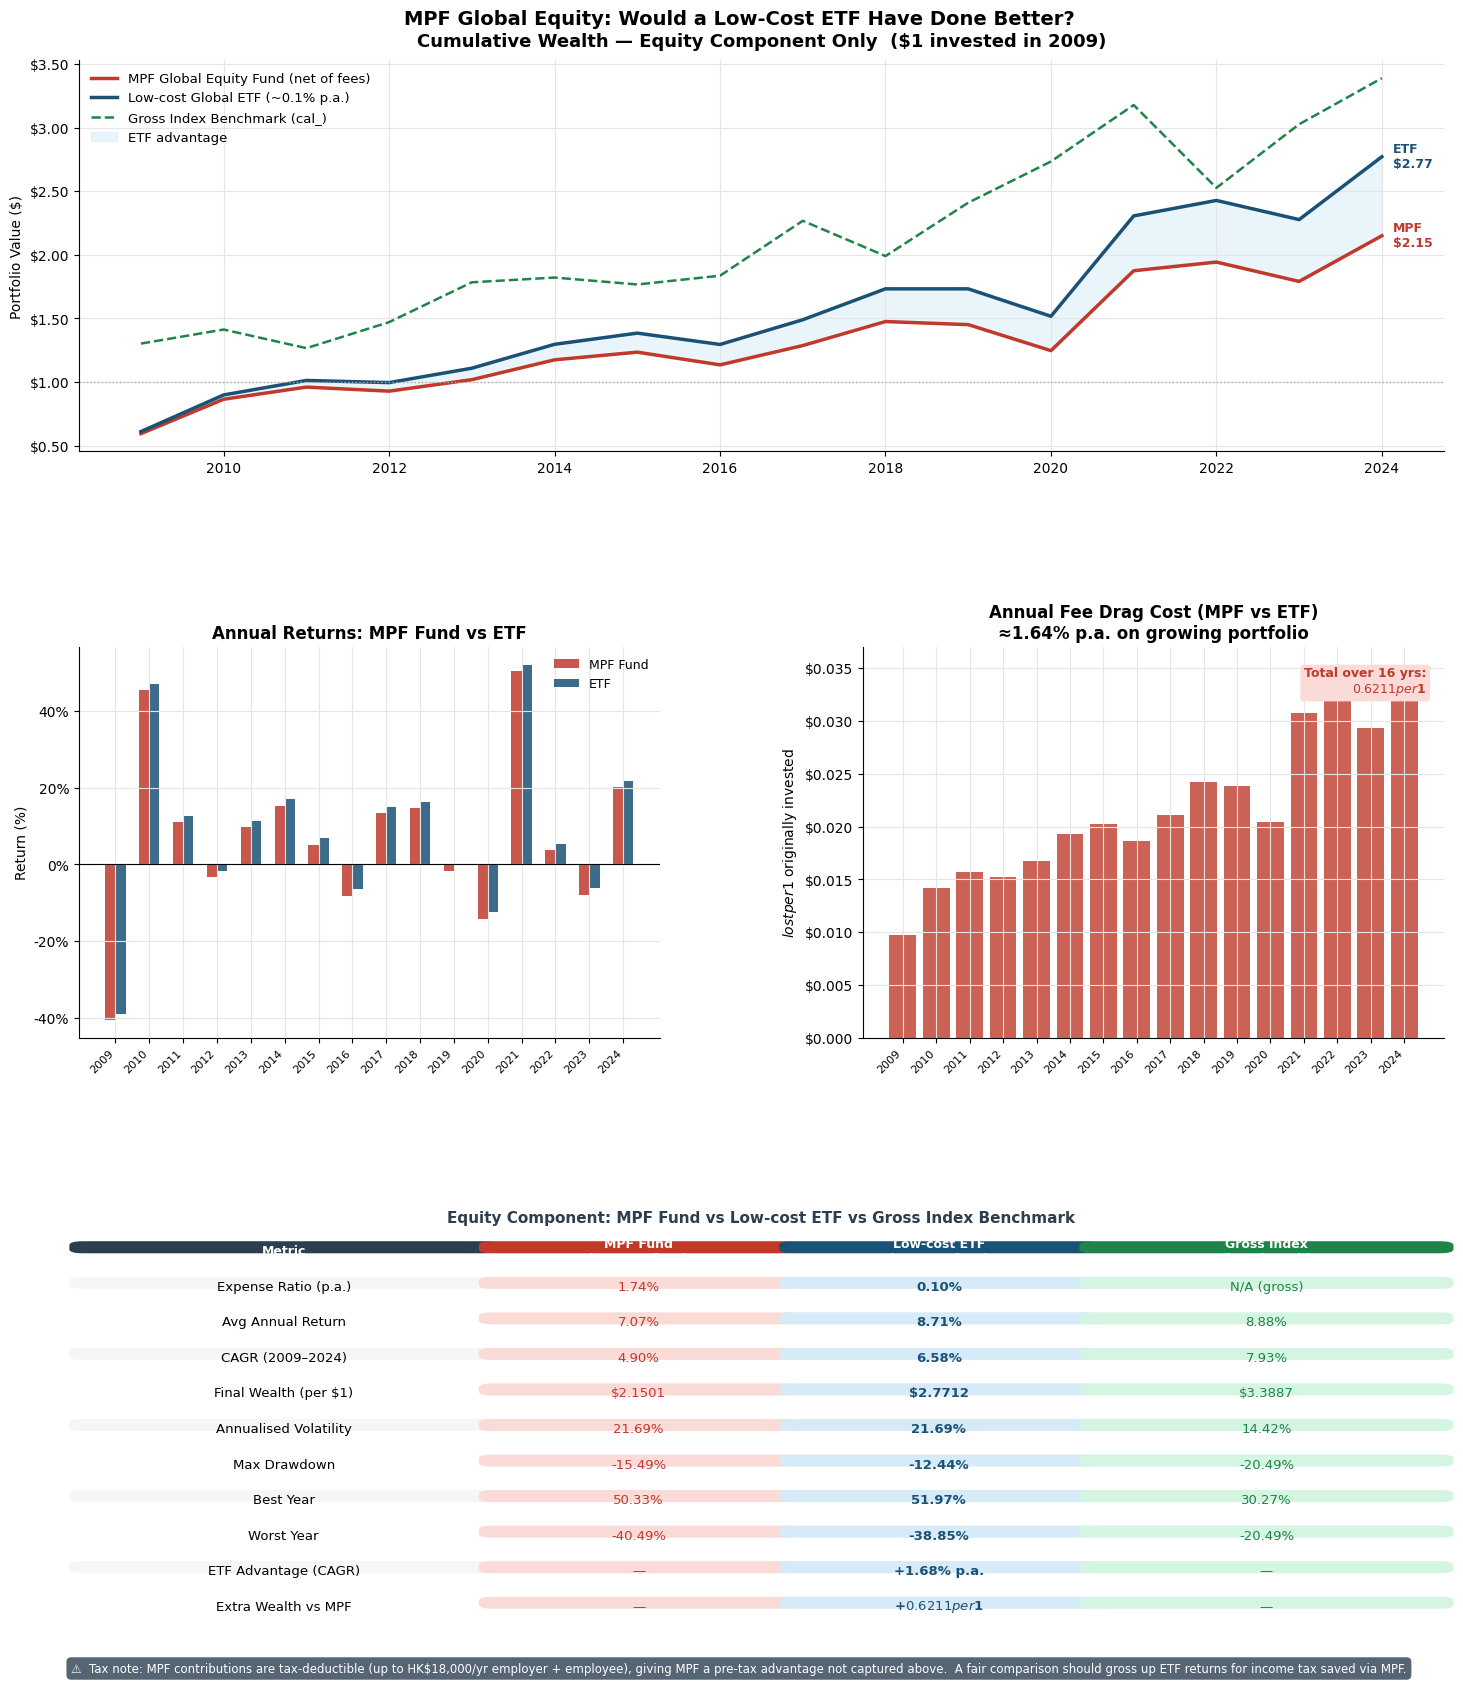

In [25]:
COL_YEAR  = "hk_year"
COL_GL_EQ = "hk_GlobalEquityLargeCap"   # MPF fund net return (HKD, after fees)
COL_INDEX = "cal_GlobalEquityLargeCap"  # Gross benchmark (calendar-year index)

START_YEAR = 2009
df = category_df[category_df[COL_YEAR] >= START_YEAR].copy().reset_index(drop=True)
years = df[COL_YEAR].values.astype(int)

# ── 1. Key fee assumptions ────────────────────────────────────────────────────
# Source: MPFA Annual Report 2023; Vanguard VT / iShares IWDA factsheet
MPF_FER = 0.0174   # MPF Global Equity fund avg expense ratio ~1.74% p.a.
ETF_FER = 0.0010   # Low-cost global ETF (e.g. Vanguard VT) ~0.10% p.a.
FEE_DRAG = MPF_FER - ETF_FER  # ~1.64% p.a. advantage of ETF

# ── 2. Build three return series (equity only) ────────────────────────────────
mpf_ret   = df[COL_GL_EQ].astype(float)          # MPF fund net return
index_ret = df[COL_INDEX].astype(float)           # Gross index (USD benchmark)

# ETF return: add back MPF fees from MPF net return, then deduct ETF fee
# i.e. we treat hk_GlobalEquityLargeCap as "index_HKD - MPF_FER"
# so: ETF_HKD ≈ mpf_ret + FEE_DRAG
etf_ret = mpf_ret + FEE_DRAG

# ── 3. Cumulative wealth ($1 invested) ────────────────────────────────────────
cum_mpf   = (1 + mpf_ret).cumprod()
cum_etf   = (1 + etf_ret).cumprod()
cum_index = (1 + index_ret).cumprod()

# ── 4. Performance stats ──────────────────────────────────────────────────────
def perf_stats(rets):
    r = rets.astype(float); n = len(r)
    fw   = float((1 + r).prod())
    cagr = fw ** (1/n) - 1
    vol  = float(r.std(ddof=1))
    dd   = float(((1+r).cumprod() / (1+r).cumprod().cummax() - 1).min())
    return dict(fw=fw, cagr=cagr, vol=vol, max_dd=dd,
                best=float(r.max()), worst=float(r.min()),
                pos=int((r > 0).sum()), neg=int((r < 0).sum()))

s_mpf   = perf_stats(mpf_ret)
s_etf   = perf_stats(etf_ret)
s_index = perf_stats(index_ret)

# ── 5. COLOURS & helpers ──────────────────────────────────────────────────────
C_MPF    = "#C0392B";  C_MPF_L  = "#FADBD8"
C_ETF    = "#1A5276";  C_ETF_L  = "#D6EAF8"
C_IDX    = "#1E8449";  C_IDX_L  = "#D5F5E3"
C_HEAD   = "#2C3E50";  C_GREY_L = "#F4F6F7"
C_GREEN  = "#1E8449";  C_RED    = "#C0392B"

plt.rcParams.update({"font.family": "sans-serif",
                     "axes.spines.top": False, "axes.spines.right": False,
                     "axes.grid": True, "grid.color": "#E5E5E5", "grid.linewidth": 0.8})

fig = plt.figure(figsize=(15, 17))
fig.patch.set_facecolor("white")
gs  = GridSpec(3, 2, figure=fig, hspace=0.50, wspace=0.35,
               top=0.95, bottom=0.03, left=0.06, right=0.97)

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 1 — Cumulative wealth (full width)
# ══════════════════════════════════════════════════════════════════════════════
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(years, cum_mpf.values,   color=C_MPF, lw=2.5, label="MPF Global Equity Fund (net of fees)")
ax1.plot(years, cum_etf.values,   color=C_ETF, lw=2.5, label=f"Low-cost Global ETF (~{ETF_FER:.1%} p.a.)")
ax1.plot(years, cum_index.values, color=C_IDX, lw=1.8, ls="--", label="Gross Index Benchmark (cal_)")
ax1.fill_between(years, cum_mpf.values, cum_etf.values,
                 where=(cum_etf.values >= cum_mpf.values),
                 color=C_ETF_L, alpha=0.5, label="ETF advantage")
ax1.axhline(1, color="#AAAAAA", lw=1, ls=":")
ax1.set_title("Cumulative Wealth — Equity Component Only  ($1 invested in 2009)",
              fontsize=13, fontweight="bold", pad=10)
ax1.set_ylabel("Portfolio Value ($)")
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:.2f}"))
ax1.legend(frameon=False, fontsize=9.5)

# Annotate final values
for cum, color, label in [
    (cum_mpf,   C_MPF, f"MPF\n${cum_mpf.values[-1]:.2f}"),
    (cum_etf,   C_ETF, f"ETF\n${cum_etf.values[-1]:.2f}"),
]:
    ax1.annotate(label, xy=(years[-1], cum.values[-1]),
                 xytext=(8, 0), textcoords="offset points",
                 color=color, fontweight="bold", va="center", fontsize=9)

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 2 — Annual returns comparison
# ══════════════════════════════════════════════════════════════════════════════
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(years)); bw = 0.30
ax2.bar(x - bw/2, mpf_ret.values * 100, bw, color=C_MPF, alpha=0.85, label="MPF Fund")
ax2.bar(x + bw/2, etf_ret.values * 100, bw, color=C_ETF, alpha=0.85, label="ETF")
ax2.axhline(0, color="black", lw=0.8)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))
ax2.set_xticks(x); ax2.set_xticklabels(years, rotation=45, ha="right", fontsize=8)
ax2.set_title("Annual Returns: MPF Fund vs ETF", fontsize=12, fontweight="bold")
ax2.set_ylabel("Return (%)"); ax2.legend(frameon=False, fontsize=9)

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 3 — Fee drag: annual cost of MPF vs ETF
# ══════════════════════════════════════════════════════════════════════════════
ax3 = fig.add_subplot(gs[1, 1])
# Compounding fee drag: how much $ is lost each year on growing portfolio
cum_vals = cum_mpf.values
annual_fee_cost = cum_vals * FEE_DRAG   # approx dollar cost per $1 originally invested
ax3.bar(years, annual_fee_cost, color=C_RED, alpha=0.8)
ax3.set_title(f"Annual Fee Drag Cost (MPF vs ETF)\n≈{FEE_DRAG:.2%} p.a. on growing portfolio",
              fontsize=12, fontweight="bold")
ax3.set_ylabel("$ lost per $1 originally invested")
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:.3f}"))
ax3.set_xticks(years); ax3.set_xticklabels(years, rotation=45, ha="right", fontsize=8)
total_fee_cost = cum_etf.values[-1] - cum_mpf.values[-1]
ax3.text(0.97, 0.95, f"Total over 16 yrs:\n${total_fee_cost:.4f} per $1",
         transform=ax3.transAxes, ha="right", va="top",
         fontsize=9, color=C_RED, fontweight="bold",
         bbox=dict(boxstyle="round,pad=0.3", facecolor=C_MPF_L, linewidth=0))

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 4 — Comparison table (full width, bottom)
# ══════════════════════════════════════════════════════════════════════════════
ax4 = fig.add_subplot(gs[2, :])
ax4.set_axis_off()

mpf_avg  = float(mpf_ret.mean())
etf_avg  = float(etf_ret.mean())
idx_avg  = float(index_ret.mean())

table_rows = [
    # label                         MPF                          ETF                           Index (gross)         better
    ("Expense Ratio (p.a.)",        f"{MPF_FER:.2%}",            f"{ETF_FER:.2%}",             "N/A (gross)",        "etf"),
    ("Avg Annual Return",           f"{mpf_avg:.2%}",            f"{etf_avg:.2%}",             f"{idx_avg:.2%}",     "etf"),
    ("CAGR (2009–2024)",            f"{s_mpf['cagr']:.2%}",      f"{s_etf['cagr']:.2%}",       f"{s_index['cagr']:.2%}", "etf"),
    ("Final Wealth (per $1)",       f"${s_mpf['fw']:.4f}",       f"${s_etf['fw']:.4f}",        f"${s_index['fw']:.4f}",  "etf"),
    ("Annualised Volatility",       f"{s_mpf['vol']:.2%}",       f"{s_etf['vol']:.2%}",        f"{s_index['vol']:.2%}",  "etf"),
    ("Max Drawdown",                f"{s_mpf['max_dd']:.2%}",    f"{s_etf['max_dd']:.2%}",     f"{s_index['max_dd']:.2%}", "etf"),
    ("Best Year",                   f"{s_mpf['best']:.2%}",      f"{s_etf['best']:.2%}",       f"{s_index['best']:.2%}",  "etf"),
    ("Worst Year",                  f"{s_mpf['worst']:.2%}",     f"{s_etf['worst']:.2%}",      f"{s_index['worst']:.2%}", "etf"),
    ("ETF Advantage (CAGR)",        "—",f"+{(s_etf['cagr']-s_mpf['cagr']):.2%} p.a.","—",     "etf"),
    ("Extra Wealth vs MPF",         "—",f"+${s_etf['fw']-s_mpf['fw']:.4f} per $1","—",         "etf"),
]

col_labels = ["Metric", f"MPF Fund\n(~{MPF_FER:.2%} fees)", f"Low-cost ETF\n(~{ETF_FER:.2%} fees)",
              "Gross Index\n(benchmark)"]
col_x = [0.0, 0.30, 0.52, 0.74]
col_w = [0.30, 0.22, 0.22, 0.26]
n_rows = len(table_rows) + 1
row_h  = 1.0 / n_rows

def draw_cell(ax, row, col, text, bg, fg="black", bold=False, size=9.5):
    x = col_x[col]; y = 1.0 - (row + 1) * row_h
    rect = mpatches.FancyBboxPatch(
        (x + 0.003, y + 0.05), col_w[col] - 0.006, row_h - 0.08,
        boxstyle="round,pad=0.01", linewidth=0,
        facecolor=bg, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(x + col_w[col]/2, y + row_h/2, text,
            transform=ax.transAxes, ha="center", va="center",
            fontsize=size, fontweight="bold" if bold else "normal",
            color=fg, fontfamily="sans-serif")

ax4.text(0.5, 1.02,
         "Equity Component: MPF Fund vs Low-cost ETF vs Gross Index Benchmark",
         transform=ax4.transAxes, ha="center", va="bottom",
         fontsize=11, fontweight="bold", color=C_HEAD)

hdr_colors = [C_HEAD, C_MPF, C_ETF, C_IDX]
for j, (lbl, hc) in enumerate(zip(col_labels, hdr_colors)):
    draw_cell(ax4, 0, j, lbl, hc, fg="white", bold=True, size=9)

for i, (label, v_mpf, v_etf, v_idx, _) in enumerate(table_rows):
    r  = i + 1
    bg = C_GREY_L if i % 2 == 0 else "white"
    draw_cell(ax4, r, 0, label,  bg,      "black",  False)
    draw_cell(ax4, r, 1, v_mpf,  C_MPF_L, C_MPF,   False)
    draw_cell(ax4, r, 2, v_etf,  C_ETF_L, C_ETF,   True)
    draw_cell(ax4, r, 3, v_idx,  C_IDX_L, C_IDX,   False)

# ── Super title & tax note ────────────────────────────────────────────────────
fig.suptitle("MPF Global Equity: Would a Low-Cost ETF Have Done Better?",
             fontsize=14, fontweight="bold", y=0.98)

fig.text(0.5, 0.002,
         "⚠️  Tax note: MPF contributions are tax-deductible (up to HK$18,000/yr employer + employee), "
         "giving MPF a pre-tax advantage not captured above.  "
         "A fair comparison should gross up ETF returns for income tax saved via MPF.",
         ha="center", fontsize=8.5, color="white", wrap=True,
         bbox=dict(boxstyle="round,pad=0.4", facecolor="#566573", linewidth=0))
